<a href="https://colab.research.google.com/github/KaroAntonio/climate-social-analysis/blob/main/notebooks/Climate_Conversation_Topic_Modelling_Model_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Climate Conversation Topic Modelling - Model Evaluation

Overarching Data Problem:   
*What Topics can be extracted from climate tweets and what is the measurable relevance of those topics.*

We've performed Data Wrangling, Exploration, Preprocessin, and Feature Engineering. Our next step is to experiment with several models for clustering and to evaluate the performance of those models.

LDA is a classic topic modelling alg that is a good baseline to compare to. However, it does not make use of the the token / sentance embeddings, so we may be able to improve on it.

We will explore algs that determine K automatically first in order to inform K chosen for those algs that require K as an input.

**Based on metric results, we select the kmeans_9 model as the best evaluated.**

### Metrics
What are the characteristics of a 'good topic'?
* Variance Ratio Criterion
* Davies Bouldin Score
* Silhouette Score  
* Subjective Coherece & Cluster Keyword Relevence
  * Inspect the clusters manually to see if they intuitively make sense
* (Maybe) Top Tokens in agreement vs Most common tokens in disagreement
  * I propose this as:
* (Maybe) Gap Stats

### Models
We explore the following clustering/topic modelling algs.

**Models Explored:**
* HDBSCAN & UMAP (2013)
  * In: Vecs
  * Out: K, Clusters
* LDA (2003)
  * In: Tokens, K
  * Out: Topic Clusters
* Agglomerative Clustering (1980s)
  * In: Vectors
  * Out: Cluster Heirarchy

**Possible Models to Explore:**
* Mean Shift (2002)
  * In: Vecs
  * Out: K, Clusters
* Brown (1992)
  * In: Tokens
  * Out: Cluster Heirarchy
* K-MEANS? (1967)
  * In: Vecs, K
  * Out: Clusters
* BIRCH (1996)
  * In: Vecs
  * Out: Cluster Heirarchy


In [ ]:
! pip install hdbscan

In [ ]:
! pip install umap-learn

In [ ]:
! pip install sentence-transformers

In [4]:
from google.colab import drive
import pandas as pd
import numpy as np
from nltk import FreqDist
from easydict import EasyDict

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cut_tree

import matplotlib.pyplot as plt
import umap
from sentence_transformers import SentenceTransformer

# models
import hdbscan
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

# models - LDA
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Data paths
DRIVE_DIR = "/content/drive/MyDrive/Climate Social Analysis/data/"
PREPROCESSED_TOKENS_PATH = f"{DRIVE_DIR}topic_modelling_preprocessed_tokens_1m.csv"
TWEET_EMBEDDINGS_PATH = f"{DRIVE_DIR}topic_modelling_tweet_embeddings_1m.csv"
TWEET_PCA_FEATURES_PATH = f"{DRIVE_DIR}topic_modelling_tweet_pca_features_1m.csv"
WORD_VECTOR_SUBSET_PATH = f"{DRIVE_DIR}topic_modelling_word_vector_subset.csv"

In [6]:
# Load Data
# Load Tweet Embeddings
tweet_embeddings_df = pd.read_csv(TWEET_EMBEDDINGS_PATH, index_col='id')
tokens_str_df = pd.read_csv(PREPROCESSED_TOKENS_PATH, index_col='id')
#tweet_pca_features_df = pd.read_csv(TWEET_PCA_FEATURES_PATH, index_col='id')
word_vector_subset_df = pd.read_csv(WORD_VECTOR_SUBSET_PATH)

In [7]:
# Prep Token Data
tokens_str_df = tokens_str_df.loc[tweet_embeddings_df.index]

word_vector_subset_df = pd.read_csv(WORD_VECTOR_SUBSET_PATH)
word_vector_subset_df.set_index('Unnamed: 0', inplace=True)

# This is a lookup of the vocab we're working with
vocab = word_vector_subset_df.index
vocab_set = set(vocab)
vocab = [str(e) for e in list(vocab_set)] #
vocab_idx_lookup = {vocab[i]:i for i in range(len(vocab))}
print(f"Vocab size: {len(vocab)}")

# Unpack the token lists
tokens_sr = tokens_str_df.apply(lambda x: x.str.split())['processed_tokens_str']

# Retain only tokens in vocab
tokens_sr = tokens_sr.apply(lambda ts: [t for t in ts if t in vocab_set])

# Prep a token dataset without the climate key stopwords
climate_stop_words = ['climate', 'change','global','warming']
tokens_noccgw_sr = tokens_sr.apply(lambda ts: [t for t in ts if t not in climate_stop_words])

Vocab size: 28862


## Metrics

We define the metrics to evulate all our models by.

In [97]:
# Metric and Topic funcs

def compute_clustering_metrics(X, labels):
  metrics = {}

  # Compute silhouette score
  # silhouette score is very compute intensive as it computes dists pair to pair
  #metrics['sil'] = silhouette_score(X, labels)
  #print(f"Silhouette Score (Best=+1, Fuzzy=0, Warning=-1): {metrics['sil']}")

  # Compute Calinski-Harabasz Score
  metrics['var_ratio'] = calinski_harabasz = calinski_harabasz_score(X, labels)
  print(f"Calinski-Harabasz / Variance Ratio Score (Best=Relative Max): {metrics['var_ratio']}")

  # Compute Davies Bouldin Score
  metrics['db'] = davies_bouldin_score(X, labels)
  print(f"Davies Bouldin Score (Best=0): {metrics['db']}")

  return metrics

def sort_topics_by_size(token_topics_sr):
  group_counts_sr = token_topics_sr.groupby(token_topics_sr).size()
  # Use 0-based index for topics
  group_counts_sr = group_counts_sr.sort_index().reset_index(drop=True)
  sorted_groups_sr = group_counts_sr.sort_values(ascending=False)
  return sorted_groups_sr

def left_align(df: pd.DataFrame):
    left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
    left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector='th', props=[('text-align', 'left')])]
    )
    return left_aligned_df

def get_topic_repr_df(vocab, token_topics_sr, topic_token_score, n_rows = 30, n_cols=15):
  # build a representation of all topics to visually inspect
  # each col is a topic ordered in descending order of size
  # each row is the top tokens in that topic, ordered by some metric
  # token is vocab idx of token
  # topic is topic idx in original modelling
  # topic_token_score['token']['topic'] = score

  # TODO: Sort cols by topic size

  def format_token_score(token_idx, score):
    token = vocab[token_idx]
    return f'{score:.3f} {token}'

  formatted_topic_tokens = {}
  for topic_idx in range(topic_token_score.shape[1]):
    sorted_topic_tokens_sr = pd.Series(topic_token_score[:, topic_idx]).sort_values(ascending=False)[:n_rows]
    formatted_topic = [format_token_score(token_idx, score) for token_idx, score in  sorted_topic_tokens_sr.items()]
    formatted_topic_sr = pd.Series(formatted_topic)
    formatted_topic_tokens[topic_idx] = formatted_topic_sr

  # Get topic sizes to sort topic cols by
  topic_sizes = sort_topics_by_size(token_topics_sr)
  sorted_topic_idxs = topic_sizes.index
  # Build topic repr df
  topic_repr_df = pd.DataFrame(formatted_topic_tokens, columns=sorted_topic_idxs)
  # Add in topic sizes as row
  topic_repr_df = pd.concat([topic_sizes.to_frame().T, topic_repr_df], ignore_index=True).rename(index={0: 'size'})
  # Select n_cols
  topic_repr_df = topic_repr_df[topic_repr_df.columns[:n_cols]]

  return left_align(topic_repr_df)

def get_cluster_tf_idf(topic_token_str, n_total):
  # Compute the TF-IDF vectors for each cluster,
  # topic_token_str : for each topic, a combined str of all docs
  # tf_idf.shape = (n tokens, n topics)
  count_vec = CountVectorizer().fit(topic_token_str)
  t = count_vec.transform(topic_token_str).toarray()
  w = t.sum(axis=1)
  tf = np.divide(t.T, w)
  sum_t = t.sum(axis=0)
  idf = np.log(np.divide(n_total, sum_t)).reshape(-1, 1)
  tf_idf = np.multiply(tf, idf)
  return tf_idf, count_vec

def extract_top_n_words_per_topic(tf_idf, count_vec, docs_per_topic, n=20):
    words = count_vec.get_feature_names_out()
    labels = list(docs_per_topic.topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['topic'])
                     .token_str
                     .count()
                     .reset_index()
                     .rename({"topic": "topic", "token_str": "size"}, axis='columns')
                     .sort_values("size", ascending=False))
    return topic_sizes

def build_topic_token_str(tokens_df):
  return tokens_df.groupby(['topic'], as_index = False).agg({'token_str': ' '.join})

# Build topic_token_tfidf_score
# TODO: Generalize this for use. by all models
# a lookup mat of rows=tokens , cols=topics
def build_topic_token_tf_idf_score(vocab_idx_lookup, top_n_words):
  topic_token_tfidf_score = np.zeros((len(vocab), len(top_n_words)))
  for topic_idx, token_scores in enumerate(top_n_words.values()):
    for token, tf_idf_score in token_scores:
      topic_token_tfidf_score[vocab_idx_lookup[token], topic_idx] = tf_idf_score
  return topic_token_tfidf_score

In [9]:
# Visualization Funcs

def display_labels_umap(X, labels):
  # Visualize Clusters as reduced by UMAP
  # Use umap to reduce dims to 2
  umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(X)
  result = pd.DataFrame(umap_data, columns=['x', 'y'])
  result['labels'] = labels

  # Visualize clusters
  fig, ax = plt.subplots(figsize=(10, 8))
  outliers = result.loc[result.labels == -0, :]
  clustered = result.loc[result.labels != -0, :]
  plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
  plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
  plt.colorbar()

def display_labels_pca(X, labels, title='Data Colored by Clusters (PCA)'):
    # Visualize Clusters as reduced by PCA
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(X)

    result = pd.DataFrame(pcs, columns=['x', 'y'])
    result['labels'] = labels

    fig, ax = plt.subplots(figsize=(10, 8))
    outliers = result.loc[result.labels == -0, :]
    clustered = result.loc[result.labels != -0, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
    plt.colorbar()
    plt.title(title)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

## Explore Models

In [10]:
# Create sentence Embeddings
# Prep data sample
tokens_noccgw_str_sr = tokens_noccgw_sr.apply(lambda ts: ' '.join(ts))

# Train Sentence level tweet embeddings
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(tokens_noccgw_str_sr.values, show_progress_bar=True)

Batches:   0%|          | 0/31247 [00:00<?, ?it/s]

In [ ]:
# Sample the dataset for testing
N_all = len(tokens_sr)
#N_sample = 100000
N_sample = 10000
np.random.seed(42)
sample_idxs = np.random.randint(low=0, high=N_all-1, size=N_sample)
sample_ids = tokens_noccgw_sr.iloc[sample_idxs].index

# Generate the various forms of X that are used by the algs
# Tokens
X_t = tokens_noccgw_sr.iloc[sample_idxs]
# Token String
X_ts = tokens_noccgw_str_sr.iloc[sample_idxs]
# Mean token embedding
X_mte = tweet_embeddings_df.iloc[sample_idxs]
# Sentence Embedding
X_se = embeddings[sample_idxs]
# UMAP is an effective Dimensionality reducing alg that can be used to reduce dims
# for clustering and visualization puproses
X_ue = umap.UMAP(n_neighbors=30, n_components=8, metric='cosine').fit_transform(X_se)

### UMAP & HDBSCAN & TF-IDF

TODO: Attempt SentenceTransformer (Distilber)

IDEA: Explore Using closest Token Vecs to lookup topic labels

Cluster with UMAP and HDBSCAN

In [14]:
# cluster embeddings
# outliers = -1
clusters = hdbscan.HDBSCAN(min_cluster_size=50,
                          # Default is min_samples=15, setting it lower seems to increase the cluster coverage
                          min_samples=1,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(X_ue)

In [15]:
# Shift the top labels so the range is 0 ->
topics_hdb = clusters.labels_ + 1

In [16]:
# Label Rows as a cluster
X_ts_pred_df = pd.DataFrame({
    'token_str':X_ts,
    'topic':topics_hdb
})

In [17]:
#display_labels_umap(X_se, topics_hdb)

In [18]:
# For each topic, get a str of all topic tweet strs combined
topic_token_str = build_topic_token_str(X_ts_pred_df)
topic_token_str.describe() #

,topic
count,5.000000
mean,2.000000
std,1.581139
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,4.000000


In [19]:
tf_idf, count_vec = get_cluster_tf_idf(topic_token_str.token_str.values, N_sample)
top_n_words = extract_top_n_words_per_topic(tf_idf, count_vec, topic_token_str, n=20)
topic_sizes = extract_topic_sizes(X_ts_pred_df)
print(f'N Topics: {len(topic_sizes)}')
topic_sizes

N Topics: 5


,topic,size
4,4,49222
1,1,464
0,0,177
3,3,86
2,2,51


In [20]:
# Reduce N Clusters
# by Merging the smallest topics with the closest cosine dists for TF-IDF scores
# 1. Calc cosine dist between all clusters

def reduce_clusters_to_n_topics(og_clustered_df, topic_token_str, total_n_token_strs, target_n_topics=30):
  clustered_df = og_clustered_df.copy()

  # Calculate new topic words
  tf_idf, count_vec = get_cluster_tf_idf(topic_token_str.token_str.values, total_n_token_strs)
  top_n_words = extract_top_n_words_per_topic(tf_idf, count_vec, topic_token_str, n=20)

  while len(top_n_words) > target_n_topics:

    # Calculate cosine similarity between topics
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)
    # Ignore row 0 (outliers)
    # by setting the outliers to inf dist from other clusters
    similarities[:,0] = -np.inf

    # Get smallest topic to merge
    topic_sizes = extract_topic_sizes(clustered_df)
    # The smallest topic is the last in the sorted list
    smallest_topic_id = topic_sizes.iloc[-1].topic
    # Topic to merge is the closest
    topic_to_merge_id = np.argmax(similarities[smallest_topic_id])

    # Adjust topics
    # Apply nearest topic id to smallest topic rows
    clustered_df.loc[clustered_df.topic == smallest_topic_id, "topic"] = topic_to_merge_id

    # Map new topic ids to new range of topic ids
    # since there is now 1 less topic
    old_topics = clustered_df.sort_values("topic").topic.unique()
    map_topics = {old_topic_id: i for i, old_topic_id in enumerate(old_topics)}
    clustered_df.topic = clustered_df.topic.map(map_topics)

    # Compute new Topic structures: tf_idf, top_n_words
    topic_token_str = build_topic_token_str(clustered_df)
    tf_idf, count_vec = get_cluster_tf_idf(topic_token_str.token_str.values, total_n_token_strs)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count_vec, topic_token_str, n=20)

    print(f'N Topics: {len(top_n_words)}')

  return clustered_df, tf_idf, top_n_words, topic_token_str

res = reduce_clusters_to_n_topics(X_ts_pred_df, topic_token_str, N_sample)
X_ts_pred_reduced_df, tf_idf, top_n_words, topic_token_str = res
topic_sizes = extract_topic_sizes(X_ts_pred_reduced_df)
top_n_words = extract_top_n_words_per_topic(tf_idf, count_vec, topic_token_str, n=20)

In [21]:
print(f'N Topics: {len(topic_sizes)}')
print(topic_sizes.head(5))
print(topic_sizes.tail(5))

N Topics: 5
   topic   size
4      4  49222
1      1    464
0      0    177
3      3     86
2      2     51
   topic   size
4      4  49222
1      1    464
0      0    177
3      3     86
2      2     51


In [22]:
# Plot Final Clusters
#display_labels_umap(X_se, topics_hdb)

In [23]:
# Let's compare to what structure we can see with pca
#display_labels_pca(X_se, topics_hdb)

In [24]:
metrics = compute_clustering_metrics(X_ue, topics_hdb)

Calinski-Harabasz / Variance Ratio Score (Best=Relative Max): 8860.246589960236
Davies Bouldin Score (Best=0): 1.346931292091353


In [25]:
# Inspect the topics Produced by 'str_embedding_umap_hdbscan' by tf-idf
topic_token_tfidf_score_hdb = build_topic_token_tf_idf_score(vocab_idx_lookup, top_n_words)
token_topics_sr = pd.Series(topics_hdb, index=sample_ids)
get_topic_repr_df(vocab, token_topics_sr, topic_token_tfidf_score_hdb, 15, 10)

,4,1,0,3,2
size,49222,464,177,86,51
1,0.019 action,10.127 bundle,0.208 hi,0.535 jay,0.774 warrior
2,0.016 world,0.000 slavery,0.195 reason,0.512 candidate,0.682 ready
3,0.015 ha,0.000 bran,0.181 follow,0.372 committed,0.678 jay
4,0.015 say,0.000 triage,0.175 love,0.360 moment,0.635 movement
5,0.015 people,0.000 blunt,0.174 translate,0.327 movement,0.538 join
6,0.014 new,0.000 reuse,0.171 youre,0.276 join,0.340 combatting
7,0.014 like,0.000 geared,0.164 please,0.272 fight,0.306 committed
8,0.014 year,0.000 hovering,0.162 sing,0.207 combatting,0.295 moment
9,0.013 need,0.000 akong,0.162 hot,0.199 warrior,0.289 fight


### LDA

In [26]:
# Convert token lists into bag-of-words representation
dictionary = Dictionary(X_t)

# Filter out tokens that appear in less than 5 documents or more than 50% of the documents
#dictionary.filter_extremes(no_below=5, no_above=0.5)

# Convert token lists into corpus (bag-of-words representation)
corpus_bow = [dictionary.doc2bow(tokens) for tokens in X_t]

In [27]:
# Train the LDA model
lda_model = LdaMulticore(corpus=corpus_bow,
                         id2word=dictionary,
                         num_topics=9,  # You can change the number of topics as needed
                         workers=4,      # Number of CPU cores to use for parallelization
                         passes=20,      # Number of passes over the corpus
                         random_state=42)  # Set a random seed for reproducibility

# Interpreting the Topics
# Print the topics and their top words
for topic_num, topic_words in lda_model.print_topics(num_topics=-1, num_words=10):
    print(f'Topic {topic_num}: {topic_words}')

# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, corpus=corpus_bow, dictionary=dictionary, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print(f'\nCoherence Score: {coherence_lda}')

Topic 0: 0.015*"people" + 0.015*"like" + 0.014*"real" + 0.013*"believe" + 0.013*"think" + 0.012*"dont" + 0.010*"know" + 0.010*"thing" + 0.008*"get" + 0.008*"ha"
Topic 1: 0.034*"year" + 0.013*"scientist" + 0.013*"weather" + 0.010*"time" + 0.010*"ha" + 0.009*"degree" + 0.009*"say" + 0.008*"record" + 0.008*"last" + 0.007*"winter"
Topic 2: 0.024*"science" + 0.011*"al" + 0.010*"gore" + 0.008*"denier" + 0.007*"education" + 0.006*"politics" + 0.006*"policy" + 0.005*"economy" + 0.005*"school" + 0.005*"de"
Topic 3: 0.045*"action" + 0.020*"environment" + 0.013*"effect" + 0.012*"world" + 0.012*"impact" + 0.011*"arctic" + 0.010*"energy" + 0.008*"learn" + 0.008*"u" + 0.008*"save"
Topic 4: 0.012*"sea" + 0.012*"join" + 0.011*"level" + 0.010*"fight" + 0.008*"world" + 0.007*"human" + 0.007*"talk" + 0.006*"un" + 0.006*"movement" + 0.006*"rising"
Topic 5: 0.011*"need" + 0.010*"day" + 0.009*"make" + 0.009*"act" + 0.008*"today" + 0.008*"weather" + 0.006*"hot" + 0.006*"new" + 0.006*"check" + 0.006*"call"
To

In [28]:
# Get topic cluster for each row
topics_lda = []
for bow in corpus_bow:
  bow_topic_distribution = lda_model.get_document_topics(bow)
  most_probable_topic = max(bow_topic_distribution, key=lambda x: x[1])
  topics_lda.append(most_probable_topic[0])
topics_lda = np.array(topics_lda)

In [29]:
# How many docs per cluster?
topics_lda_sr = pd.Series(topics_lda)
topics_lda_sr.value_counts()

0    12167
6     6479
3     5677
1     5346
8     4726
5     4595
7     3918
4     3876
2     3216
dtype: int64

In [30]:
# We're using the umap 5d embeddings, which is an embedded space that LDA did not really work with
# Not sure if there's a token vec that could be used
metrics = compute_clustering_metrics(X_ue, topics_lda_sr)

Calinski-Harabasz / Variance Ratio Score (Best=Relative Max): 403.35528185226286
Davies Bouldin Score (Best=0): 8.359828843404621


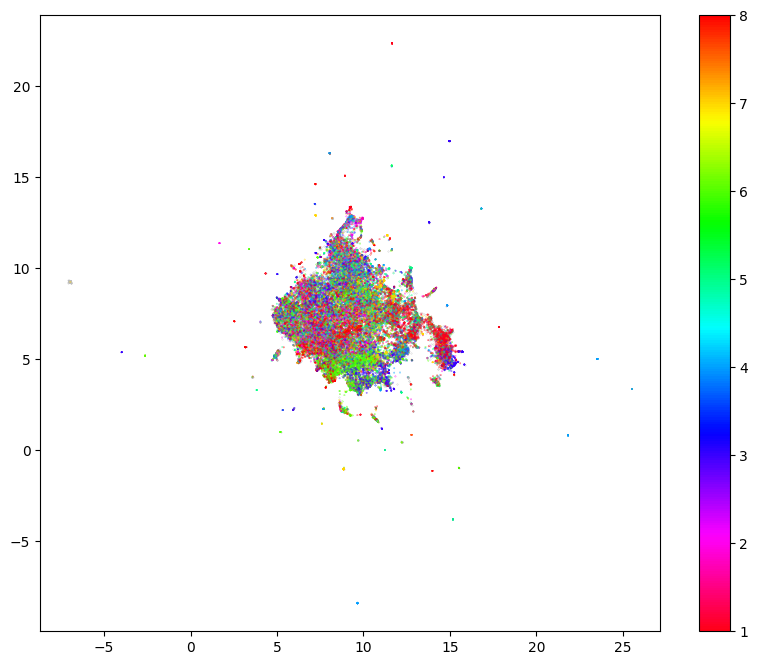

In [31]:
# Plot Final Clusters
display_labels_umap(X_se, topics_lda_sr)

In [32]:
X_ts_pred_lda = pd.DataFrame({
    'token_str':X_ts,
    'topic':topics_lda
})
topic_token_str_lda = build_topic_token_str(X_ts_pred_lda)
cluster_tf_idf_lda, count_vec_lda = get_cluster_tf_idf(topic_token_str_lda.token_str.values, N_sample)

In [33]:
# Inspect the topics Produced by 'str_embedding_umap_hdbscan' by tf-idf
top_n_words_lda = extract_top_n_words_per_topic(cluster_tf_idf_lda, count_vec_lda, topic_token_str_lda, n=20)
topic_token_tfidf_score_lda = build_topic_token_tf_idf_score(vocab_idx_lookup, top_n_words_lda)
topics_lda_sr = pd.Series(topics_lda, index=sample_ids)

get_topic_repr_df(vocab, topics_lda_sr, topic_token_tfidf_score_lda, 15, 10)

,0,6,3,1,8,5,7,4,2
size,12167,6479,5677,5346,4726,4595,3918,3876,3216
1,0.033 like,0.038 energy,0.085 action,0.058 year,0.055 trump,0.029 need,0.072 latest,0.035 join,0.046 science
2,0.032 people,0.037 carbon,0.050 environment,0.037 weather,0.037 obama,0.026 day,0.063 thanks,0.032 sea,0.034 al
3,0.030 believe,0.035 emission,0.033 energy,0.034 scientist,0.035 new,0.025 make,0.053 daily,0.030 level,0.030 gore
4,0.030 real,0.027 fuel,0.033 impact,0.029 record,0.033 report,0.023 today,0.028 news,0.029 fight,0.024 denier
5,0.029 think,0.027 fight,0.029 world,0.027 time,0.026 news,0.023 act,0.022 help,0.028 jay,0.023 education
6,0.029 dont,0.025 could,0.028 arctic,0.025 ha,0.026 say,0.022 weather,0.021 sustainability,0.026 movement,0.021 policy
7,0.025 thing,0.023 action,0.028 effect,0.025 degree,0.024 oil,0.019 hot,0.021 issue,0.025 world,0.021 de
8,0.024 know,0.023 gas,0.023 tree,0.025 say,0.022 bill,0.019 new,0.020 impact,0.024 un,0.020 economy
9,0.021 ha,0.023 fossil,0.022 learn,0.023 ice,0.022 plan,0.019 call,0.019 science,0.021 talk,0.019 politics


### K-Means

In [34]:
# Fit K-means for each K and calculate inertia
k_values = range(5, 30)
inertias = []
topics_for_k = {}
for k in k_values:
    kmeans = KMeans(n_init='auto', n_clusters=k, random_state=42)
    kmeans.fit(X_ue)
    inertias.append(kmeans.inertia_)
    topics_for_k[k] = kmeans.fit_predict(X_ue)

In [35]:
# Use the scnd derivative to help choose the best K
scnd_derivatives = np.gradient(np.gradient(inertias))
index_of_max_scnd_derivative = np.argmax(scnd_derivatives)
print(scnd_derivatives)

[3128.78125    3463.58984375 2983.46484375 2510.76171875 2229.5703125
  763.44335938 -137.10058594  488.36328125 1021.30957031    9.58105469
 -338.3671875   592.06933594  462.14160156 -125.80859375 -459.86230469
 -262.43261719  606.99316406  263.70214844 -197.73828125  310.36132812
  246.81347656  -21.24121094 -122.43554688 -357.00488281 -447.58984375]


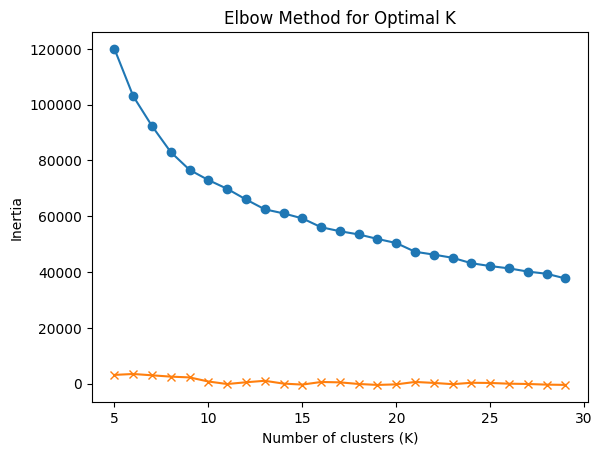

In [36]:
# Plot Elbow curve
# Looks like k=6 or k=9 are good choices
# on the other hand, we don't have too much of a risk of overfitting the clusters
# since N is much greater than k.
# By this rationale, k=24 is also a decent choice
plt.plot(k_values, inertias, marker='o')
plt.plot(k_values, scnd_derivatives, marker='x')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

### Agglomerative Heirarchical Clustering

In [37]:
# Fit BIRCH
# 10k => 3s
# max_cluster_radius = 0.15
# birch = Birch(threshold=max_cluster_radius)

# birch.fit(X_ue)

# # Predict cluster labels
# bi_cluster_labels = birch.predict(X_ue)

In [39]:
def create_tree_from_linkage(X, to_merge):
    clusters = {}
    for i, merge in enumerate(to_merge):
        if merge[0] <= len(to_merge):
            # if it is an original point, store idx
            a = int(merge[0]) - 1
        else:
            # other wise read the cluster that has been created
            a = clusters[int(merge[0])]
        if merge[1] <= len(to_merge):
            # Handle OG point
            b = int(merge[1]) - 1
        else:
            b = clusters[int(merge[1])]
        # the clusters are 1-indexed by scipy ugh
        clusters[1 + i + len(to_merge)] = {
            'children' : [a, b]
        }
    return clusters

def build_cluster_node_lookup(lm):
  # given the linkage_matrix lm
  # build a lookup dict where as {{node_id}:{child_id_list}}
  # where:
  # node_id is a cluster id
  # child_id_list is a list of either cluster ids or ids from the original data
  lookup = {}
  for i, lm_row in enumerate(lm):
    sbc1_idx, sbc2_idx, dist, n_x = lm_row

    # If the subcluster index is one of the OG datapoints, shift index
    cid1 = int(sbc1_idx - 1 if sbc1_idx <= len(lm) else sbc1_idx)
    cid2 = int(sbc2_idx - 1 if sbc2_idx <= len(lm) else sbc2_idx)

    cluster_node_idx = 1 + i +len(lm)
    lookup[cluster_node_idx] = [cid1, cid2]
  return lookup


In [40]:
# Retrieve the linkage matrix
# This contains the tree graph we need for herirachical cluster labels
# linkage_matrix.shape = 9999, 4
# each row represents a clustering,
# for cluster i , linkage_matrix[i] =
# [subcluster_idx1, subcluster_idx2, dist, n_x]
# where n_x is N(x) from X in the cluster
N_subset = 1000
X_ue_sub = X_ue[:N_subset]
linkage_matrix = linkage(X_ue_sub, method='ward')

In [41]:
# Check that the last element is the top level,
# it is since it has all 10k elements
n_x = linkage_matrix[-1][3]
print(f'Number of elements in cluster: {n_x}')

Number of elements in cluster: 50000.0


In [42]:
cnl = build_cluster_node_lookup(linkage_matrix)

In [43]:
# WE WANT the FreqDist of tokens of a particular cluster node in the heirarchy
# to get there, we
# 1. build a lookup map from eidx > tweet id (tids) (from tweet_embeddings_df)
# 2. build a lookup of tids for each node in the clustering
# 3. then for a particular node we can build a BOW of all tweets in that cluster
# 4. then we can get the freq dist for that BOW

def convert_to_cid(cidx, N):
  # scipy's linkage_matrix uses a diff idx within the matrix for each cluster
  return 1 + cidx + N

def build_eidxs_lookup(lm):
  # Build a lookup map of cluster_id (cid) => list of embeddings idxs (eidx) in that cluster
  eidx_lookup = {}
  for i, lm_row in enumerate(lm):
    sbc1_idx, sbc2_idx, dist, n_x = lm_row
    eidxs = []
    for sub_idx in [int(sbc1_idx), int(sbc2_idx)]:
      if sub_idx <= len(lm):
        eidxs.append(sub_idx - 1)
      else:
        sub_eidxs = eidx_lookup[sub_idx]
        eidxs.extend(sub_eidxs)

    eidx_lookup[convert_to_cid(i, len(lm))] = eidxs
  return eidx_lookup

def build_bow_from_tids(tids):
  # Given a list of tids
  # build a list of all tokens for those tids
  bow = []
  for tid in tids:
    tokens = tokens_sr.loc[tid]
    bow.extend(tokens)
  return bow

def build_freqdist_for_cluster(cid):
  tids = cid_tids_lookup[cid]
  cluster_bow = build_bow_from_tids(cid_tids_lookup[cid])
  cluster_freqdist = FreqDist(cluster_bow)
  return cluster_freqdist

# 1. build a lookup map from eidx > tweet id (tids) (from tweet_embeddings_df)
cid_eidxs_lookup = build_eidxs_lookup(linkage_matrix)

# 2. build a lookup of tids for each node in the clustering
eidx_to_tid_lookup = tweet_embeddings_df.index.to_list()
# map eidxs to tids
cid_tids_lookup = {}
for cid, eidxs in cid_eidxs_lookup.items():
  tids = [eidx_to_tid_lookup[eidx] for eidx in eidxs]
  cid_tids_lookup[cid] = tids

top_cluster_idx = len(linkage_matrix)-1
top_cluster_freqs = build_freqdist_for_cluster(convert_to_cid(top_cluster_idx, len(linkage_matrix)))
# This looks correct , there's
top_cluster_freqs.most_common(20)

[('climate', 36080),
 ('change', 35678),
 ('global', 17220),
 ('warming', 16422),
 ('action', 2658),
 ('u', 2267),
 ('world', 2078),
 ('ha', 1900),
 ('people', 1884),
 ('say', 1857),
 ('new', 1779),
 ('like', 1688),
 ('year', 1608),
 ('need', 1512),
 ('trump', 1510),
 ('environment', 1503),
 ('one', 1470),
 ('energy', 1426),
 ('science', 1385),
 ('time', 1385)]

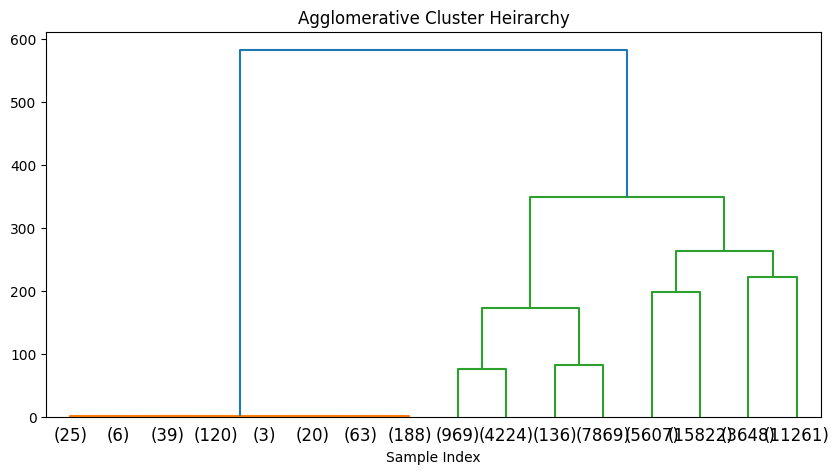

In [44]:
# Plot the dendrogram of the top N clusters of the linkage matrix
# This is a hierarchical clustering
n_top_levels = 3
plt.figure(figsize=(10, 5))
truncated = dendrogram(linkage_matrix, truncate_mode='level', p=n_top_levels)
plt.title('Agglomerative Cluster Heirarchy')
plt.xlabel('Sample Index')
#plt.ylabel('Distance')
plt.show()

In [45]:
# The idxs given in the cluster heriarchy are not what we want,
# We want the ids of the clusters that are the leaves of this
# truncated tree
# so let's cut the tree and inspect it
print(f'Leaves at lvl {n_top_levels}: {len(truncated["leaves"])}')

lvl_cluster_idx = truncated['leaves'][1]
print(lvl_cluster_idx)
top_cluster_freqs = build_freqdist_for_cluster(lvl_cluster_idx)
# This looks correct
top_cluster_freqs.most_common(20)

Leaves at lvl 3: 16
77597


[('climate', 4),
 ('change', 4),
 ('global', 3),
 ('warming', 3),
 ('carbon', 2),
 ('science', 2),
 ('understand', 2),
 ('bring', 1),
 ('another', 1),
 ('white', 1),
 ('good', 1),
 ('nonsense', 1),
 ('denialism', 1),
 ('thought', 1),
 ('diversity', 1),
 ('editorial', 1),
 ('problem', 1),
 ('first', 1),
 ('whose', 1),
 ('solution', 1)]

## Evaluate Models

In [90]:
# Model Funcs
def get_kmeans_topics(X, k):
  kmeans = KMeans(n_init='auto', n_clusters=k, random_state=42)
  return kmeans.fit_predict(X)

def get_lda_topics(X, k):
  dictionary = Dictionary(X)
  corpus_bow = [dictionary.doc2bow(tokens) for tokens in X]
  lda_model = LdaMulticore(corpus=corpus_bow,
                         id2word=dictionary,
                         num_topics=k,  # You can change the number of topics as needed
                         workers=4,      # Number of CPU cores to use for parallelization
                         passes=20,      # Number of passes over the corpus
                         random_state=42)  # Set a random seed for reproducibility
  topics_lda = []
  for bow in corpus_bow:
    bow_topic_distribution = lda_model.get_document_topics(bow)
    most_probable_topic = max(bow_topic_distribution, key=lambda x: x[1])
    topics_lda.append(most_probable_topic[0])
  return np.array(topics_lda)

def get_hdbscan_topics(X, min_cluster_size=50, min_samples=15):
  clusters = hdbscan.HDBSCAN(min_cluster_size=50,
                          # Default is min_samples=15, setting it lower seems to increase the cluster coverage
                          min_samples=min_samples,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(X)

  return clusters.labels_ + 1

print(f'Running models on Subset size: {N_sample}')
# for each model, store
# topics: assigned topics vec
# We're using k=9 and k=24 as chosen via elbow test
models = EasyDict({'topics':{}, 'metrics':{}})
models.topics.kmeans_9 = get_kmeans_topics(X_ue, k=9)
models.topics.kmeans_24 = get_kmeans_topics(X_ue, k=24)
models.topics.lda_9 = get_lda_topics(X_t, k=9)
models.topics.lda_24 = get_lda_topics(X_t, k=24)
models.topics.hdbscan_50_15 = get_hdbscan_topics(X_ue, min_cluster_size=50, min_samples=15)

Running models on Subset size: 10000


In [93]:
# Compute metrics for each model
# Silhouette Score:
# Variance Ratio Score: ratio of the between-cluster dispersion to the within-cluster dispersion
# Davies Bouldin: average similarity between each cluster and its most similar cluster, relative to the average dissimilarity within clusters
models.metrics = {}
variance_ratio_scores = []
davies_bouldin_scores = []
silhouette_scores = []

# Pre-compute pairwise_dists for silhouette scoring
pairwise_dists = pairwise_distances(X_ue)

model_names = models.topics.keys()
for model_name in model_names:
  print(f'Computing metrics for {model_name}')
  topics = models.topics[model_name]

  sil = silhouette_score(pairwise_dists, topics, metric='precomputed')
  silhouette_scores.append(sil)

  var_ratio = calinski_harabasz = calinski_harabasz_score(X_ue, topics)
  variance_ratio_scores.append(var_ratio)

  # Compute Davies Bouldin Score
  db = davies_bouldin_score(X_ue, topics)
  davies_bouldin_scores.append(db)

Computing metrics for kmeans_9
Computing metrics for kmeans_24
Computing metrics for lda_9
Computing metrics for lda_24
Computing metrics for hdbscan_50_15


In [94]:
metrics_df = pd.DataFrame({'Model':models.topics.keys(),
                          'Variance Ratio Score':variance_ratio_scores,
                          'Davies Bouldin Score':davies_bouldin_scores,
                           'Avg Silhouette Score': silhouette_scores})
# Based on the metrics Results
# k_means_9 has max(Variance Ratio Score), min(Davies Bouldin Score) and decent Silhouette Score
# hdbscan_50_15 has high Silhouette Score and top-ish Davies Bouldin Score with a mid Variance Ratio Score
metrics_df

,Model,Variance Ratio Score,Davies Bouldin Score,Avg Silhouette Score
0,kmeans_9,4100.402329,1.090415,0.301343
1,kmeans_24,3207.895413,1.132438,0.284925
2,lda_9,21.439924,18.401831,-0.049958
3,lda_24,12.473309,24.563250,-0.077033
4,hdbscan_50_15,1435.049958,0.259962,0.645049


In [102]:
# Inspect the topics Produced by 'str_embedding_umap_hdbscan' by tf-idf
def build_topic_token_tfidf_score(vocab_idx_lookup, X_ts, topics_sr, n_words=20):
  X_ts_pred = pd.DataFrame({
      'token_str':X_ts,
      'topic':topics_sr
  })
  topic_token_str = build_topic_token_str(X_ts_pred)
  cluster_tf_idf, count_vec = get_cluster_tf_idf(topic_token_str.token_str.values, N_sample)
  top_n_words = extract_top_n_words_per_topic(cluster_tf_idf, count_vec, topic_token_str, n=n_words)
  topic_token_tfidf_score = build_topic_token_tf_idf_score(vocab_idx_lookup, top_n_words)
  return topic_token_tfidf_score

for model_name in models.topics.keys():
  print(f'Inspecting topics produced by {model_name}')
  topics_sr = pd.Series(models.topics[model_name], index=sample_ids)

  topic_token_tfidf_score = build_topic_token_tfidf_score(vocab_idx_lookup, X_ts, topics_sr)

  display(get_topic_repr_df(vocab, topics_sr, topic_token_tfidf_score, 15, 15))

Inspecting topics produced by kmeans_9


,1,5,2,6,7,0,3,8,4
size,2236,1784,1351,1332,877,808,792,721,99
1,0.032 trump,0.036 new,0.036 real,0.034 energy,0.059 latest,0.078 dont,0.080 arctic,0.031 world,1.356 thing
2,0.017 people,0.027 science,0.032 action,0.034 environment,0.056 thanks,0.055 stop,0.072 ice,0.029 blame,1.352 style
3,0.016 stop,0.024 scientist,0.024 people,0.033 action,0.049 daily,0.040 cant,0.061 snow,0.027 like,1.211 geography
4,0.016 world,0.023 obama,0.022 need,0.028 water,0.049 year,0.030 never,0.054 winter,0.027 hoax,1.135 thread
5,0.015 ha,0.021 fight,0.018 believe,0.027 green,0.047 hot,0.030 nothing,0.050 cold,0.025 would,0.554 people
6,0.015 like,0.020 paris,0.018 know,0.026 help,0.043 weather,0.028 believe,0.041 canada,0.024 people,0.000 blunt
7,0.014 say,0.019 join,0.018 like,0.024 carbon,0.026 today,0.023 still,0.029 polar,0.022 say,0.000 triage
8,0.013 get,0.018 action,0.018 say,0.023 food,0.026 day,0.023 ha,0.028 action,0.021 bad,0.000 reuse
9,0.013 science,0.017 news,0.018 help,0.023 forest,0.023 extreme,0.022 one,0.027 melting,0.021 worse,0.000 geared


Inspecting topics produced by kmeans_24


,3,8,15,4,0,7,10,21,1,13,9,12,23,2,14
size,733,690,617,595,574,527,483,467,459,428,422,421,391,378,351
1,0.086 arctic,0.023 people,0.040 science,0.068 environment,0.095 dont,0.055 real,0.049 new,0.137 trump,0.024 nasa,0.059 sea,0.048 blame,0.090 weather,0.036 worse,0.049 action,0.084 food
2,0.078 ice,0.020 world,0.037 dont,0.064 energy,0.072 stop,0.038 action,0.035 year,0.040 republican,0.022 new,0.055 hurricane,0.044 hoax,0.086 hot,0.033 world,0.038 help,0.051 agriculture
3,0.064 snow,0.018 stop,0.032 scientist,0.059 green,0.049 cant,0.037 people,0.031 week,0.039 donald,0.020 scientist,0.047 flood,0.035 like,0.067 year,0.023 face,0.035 community,0.044 forest
4,0.053 winter,0.016 like,0.025 say,0.050 action,0.041 never,0.031 good,0.021 next,0.027 news,0.019 million,0.042 level,0.034 damn,0.047 extreme,0.023 ha,0.032 impact,0.039 help
5,0.052 cold,0.015 get,0.022 think,0.039 carbon,0.040 nothing,0.031 know,0.021 blog,0.026 president,0.018 science,0.040 rising,0.033 lie,0.042 record,0.023 like,0.032 need,0.034 farmer
6,0.044 canada,0.014 year,0.021 stop,0.039 sustainability,0.035 believe,0.030 earth,0.021 action,0.021 say,0.018 ha,0.034 water,0.026 know,0.041 heat,0.021 catastrophic,0.031 health,0.034 animal
7,0.031 polar,0.014 one,0.020 denying,0.032 tree,0.025 wont,0.028 human,0.020 conference,0.020 administration,0.017 world,0.033 ocean,0.025 think,0.038 summer,0.021 would,0.027 act,0.032 soil
8,0.030 melting,0.014 ha,0.018 denier,0.030 environmental,0.025 people,0.027 still,0.018 today,0.019 stop,0.017 billion,0.031 florida,0.025 would,0.037 must,0.021 biggest,0.027 public,0.029 plant
9,0.029 action,0.013 need,0.017 like,0.025 nature,0.024 slow,0.027 like,0.018 day,0.019 obama,0.017 help,0.031 rise,0.024 one,0.035 reason,0.020 get,0.026 join,0.029 pollution


Inspecting topics produced by lda_9


,3,2,0,4,1,7,6,5,8
size,1584,1484,1386,1027,967,962,949,908,733
1,0.022 like,0.035 say,0.031 ha,0.056 fight,0.026 year,0.030 new,0.050 action,0.030 hot,0.080 latest
2,0.022 people,0.032 believe,0.026 trump,0.028 join,0.025 time,0.027 science,0.047 environment,0.027 new,0.069 thanks
3,0.020 world,0.031 dont,0.025 sea,0.026 forest,0.024 could,0.024 action,0.046 energy,0.026 right,0.060 daily
4,0.020 ha,0.027 trump,0.021 blame,0.025 say,0.022 un,0.021 environment,0.032 carbon,0.025 reason,0.028 effect
5,0.019 real,0.027 like,0.021 denier,0.023 help,0.021 give,0.020 year,0.027 city,0.024 study,0.026 act
6,0.018 get,0.026 real,0.021 stop,0.022 tree,0.019 fact,0.020 issue,0.027 help,0.024 must,0.026 world
7,0.017 would,0.024 scientist,0.020 think,0.021 jay,0.019 impact,0.019 report,0.025 earth,0.023 call,0.020 al
8,0.017 take,0.023 people,0.019 level,0.020 year,0.018 trump,0.019 get,0.022 learn,0.023 follow,0.020 water
9,0.017 news,0.023 day,0.019 hoax,0.020 action,0.018 people,0.018 post,0.021 arctic,0.019 need,0.018 science


Inspecting topics produced by lda_24


,0,9,22,19,3,21,11,17,15,1,20,10,4,23,2
size,648,559,535,525,484,461,444,420,417,417,415,406,392,384,384
1,0.058 sea,0.112 action,0.038 year,0.035 like,0.027 oil,0.044 jay,0.048 made,0.036 still,0.067 trump,0.043 year,0.042 report,0.059 new,0.070 fight,0.047 world,0.038 day
2,0.047 level,0.089 environment,0.027 trump,0.034 weather,0.023 company,0.043 join,0.037 man,0.036 think,0.038 denier,0.031 one,0.030 impact,0.025 trump,0.043 help,0.030 ha,0.037 pope
3,0.034 bear,0.081 energy,0.023 say,0.034 extreme,0.023 human,0.038 movement,0.033 know,0.033 make,0.031 national,0.029 time,0.025 new,0.024 post,0.035 news,0.027 people,0.037 im
4,0.034 polar,0.049 arctic,0.022 cant,0.030 real,0.021 tell,0.036 committed,0.027 ha,0.031 snow,0.029 call,0.027 know,0.025 issue,0.023 people,0.032 state,0.026 stop,0.033 cold
5,0.032 rise,0.042 learn,0.020 hottest,0.028 need,0.021 right,0.036 fight,0.024 see,0.031 also,0.026 believe,0.027 earth,0.022 public,0.022 good,0.032 gas,0.025 tell,0.032 real
6,0.031 ha,0.037 reason,0.020 like,0.026 scientist,0.021 fossil,0.036 could,0.024 put,0.030 issue,0.025 coal,0.026 thing,0.022 year,0.020 fighting,0.029 paris,0.022 un,0.029 le
7,0.027 may,0.037 hot,0.019 long,0.026 world,0.020 like,0.035 world,0.023 trump,0.030 like,0.023 president,0.026 lie,0.021 people,0.020 industry,0.027 forest,0.021 washington,0.027 like
8,0.026 rising,0.035 tree,0.019 make,0.025 look,0.019 ha,0.035 say,0.023 agree,0.030 time,0.022 administration,0.026 two,0.021 big,0.020 say,0.027 agreement,0.021 catastrophic,0.026 francis
9,0.024 due,0.033 follow,0.019 get,0.022 get,0.019 nuclear,0.032 candidate,0.022 country,0.028 get,0.022 worse,0.025 day,0.021 health,0.019 help,0.026 say,0.020 post,0.025 scientist


Inspecting topics produced by hdbscan_50_15


,1,0
size,9901,99
1,0.018 action,1.356 thing
2,0.015 world,1.352 style
3,0.015 say,1.211 geography
4,0.015 ha,1.135 thread
5,0.015 new,0.554 people
6,0.014 people,0.000 blunt
7,0.014 like,0.000 triage
8,0.013 year,0.000 reuse
9,0.013 trump,0.000 geared


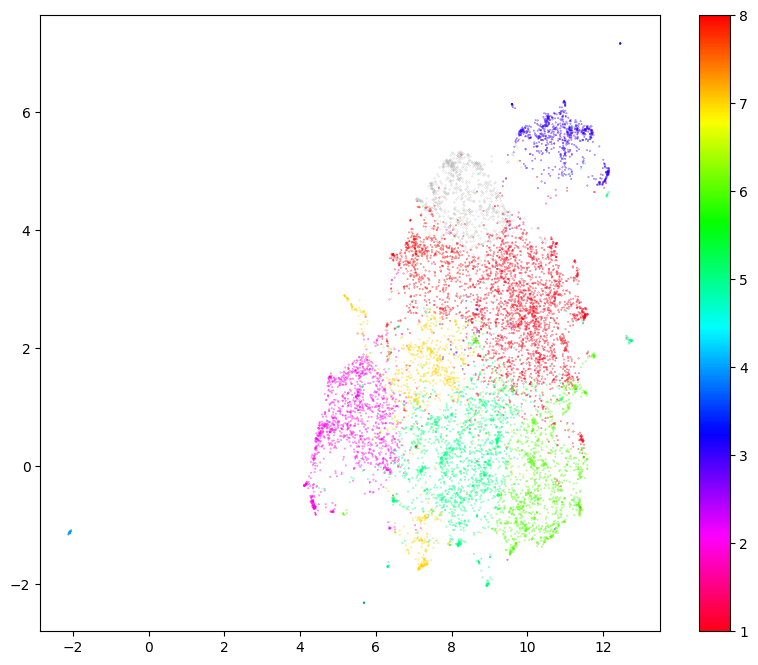

In [103]:
# Based on the Cluster Scoring and the subjective analysis of the topics,
# We select the kmeans_9 model as the 'best' model evaluated.
display_labels_umap(X_se, models.topics.kmeans_9)